In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #ignore the warning to keep ipython clean

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [4]:
train = pd.read_csv("Data/train.csv", parse_dates=['timestamp'])
y = train["price_doc"]
ylog = np.log(y)
train = train.drop(["price_doc"], axis=1)
num_train = train.shape[0]

test = pd.read_csv("Data/test.csv", parse_dates=['timestamp'])
data = pd.concat([train, test], axis=0)
print train.shape, test.shape, data.shape

(30471, 291) (7662, 291) (38133, 291)


In [19]:
top = ['metro_km_avto', 'mosque_km', 'industrial_km', 'ttk_km', 'metro_min_avto', 'public_transport_station_km',
       'sub_area', 'material', 'radiation_km', 'green_zone_km', 'railroad_km', 'kindergarten_km',
       'state', 'num_room', 'kitch_sq', 'max_floor', 'build_year', 'floor', 'life_sq', 'full_sq']

X = train[top]
X['price'] = ylog

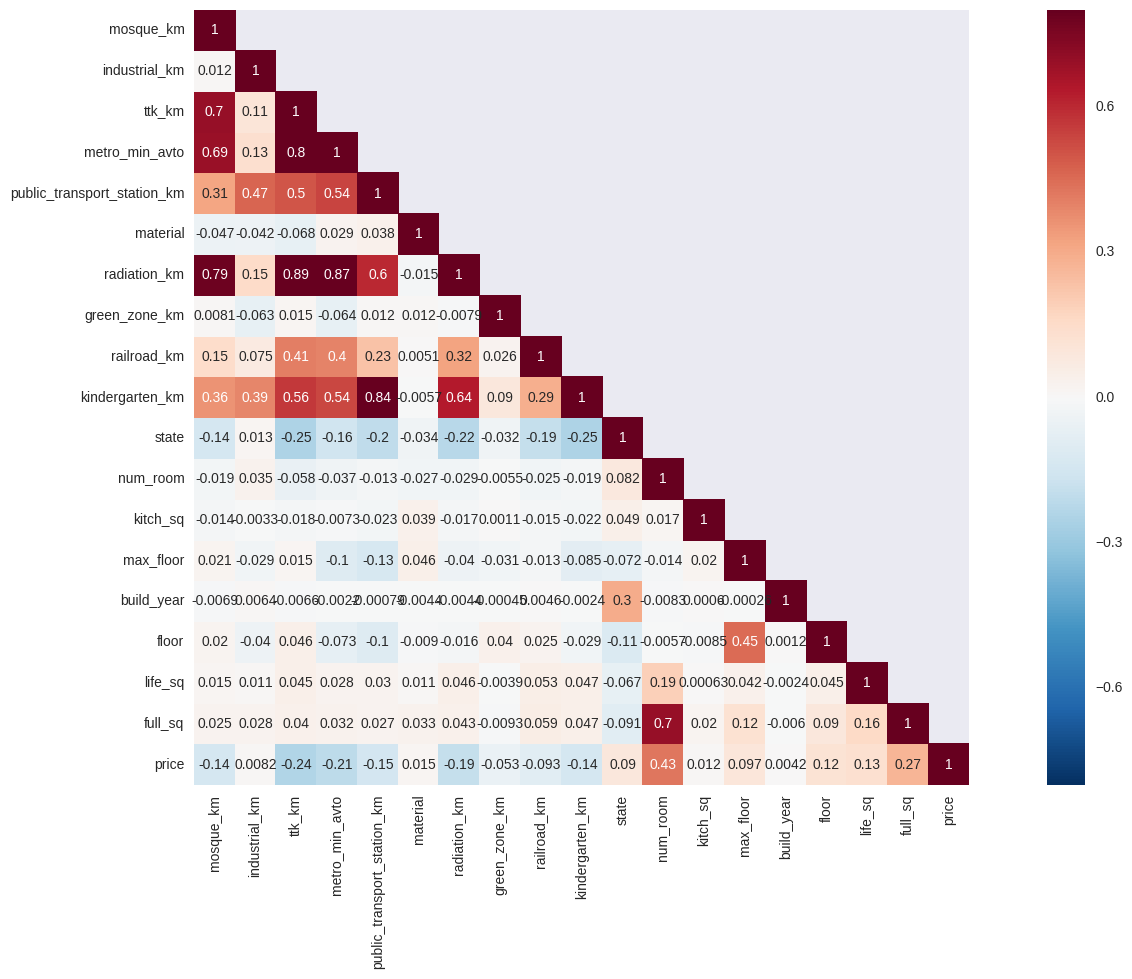

In [18]:
corrMatt = X.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

X = train[top]
numericalCol = []
for f in X.columns:
    if X[f].dtype!='object':
        numericalCol.append(f)
X_NA = X[numericalCol].dropna() 
vifDict = calculate_vif_(X_NA)
print vifDict

{'ttk_km': 13.939445770661195, 'public_transport_station_km': 4.453995817730414, 'metro_min_avto': 28.686511440701, 'build_year': 1.0787051173869688, 'floor': 4.2194420063109739, 'kindergarten_km': 5.2128579841771838, 'life_sq': 1.3778484356020582, 'material': 2.5112062765186995, 'max_floor': 7.5973486243095634, 'num_room': 13.082274938092175, 'radiation_km': 18.517545267388481, 'full_sq': 16.67258023966637, 'state': 6.7167649247598726, 'green_zone_km': 2.2200761213851146, 'industrial_km': 3.0655474075259406, 'railroad_km': 2.3263853823622385, 'kitch_sq': 1.0755236174032117, 'metro_km_avto': 33.051597272219283, 'mosque_km': 8.0373590511976172}


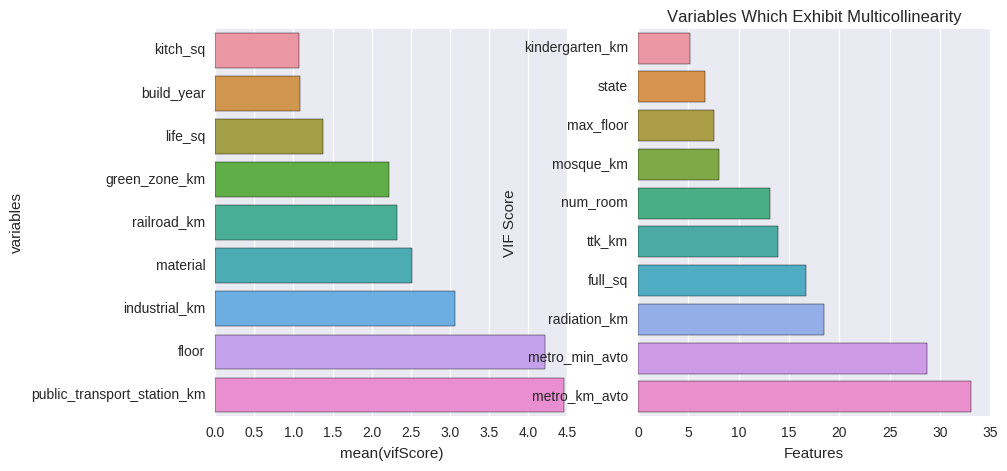

In [44]:
vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=True,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,5)
sns.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h")
sns.barplot(data=variablesWithMC.head(100),x="vifScore",y="variables",ax=ax2,orient="h")
ax2.set(xlabel='Features', ylabel='VIF Score',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='Features', ylabel='VIF Score',title="Variables Which Exhibit Multicollinearity")

In [13]:
cor_dict = corr['price'].to_dict()
del cor_dict['price']
print("List the numerical features decendingly by their correlation with price_doc:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the numerical features decendingly by their correlation with price_doc:

num_room: 	0.427692863348
full_sq: 	0.271407471303
ttk_km: 	-0.242854420487
metro_min_avto: 	-0.212059314279
radiation_km: 	-0.18984893532
public_transport_station_km: 	-0.145745403408
mosque_km: 	-0.143577219521
kindergarten_km: 	-0.142499201124
life_sq: 	0.126967578723
floor: 	0.118224229249
max_floor: 	0.0967711832625
railroad_km: 	-0.0933649197164
state: 	0.0898902357019
green_zone_km: 	-0.0534538419476
material: 	0.0145192765082
kitch_sq: 	0.0122535006529
industrial_km: 	0.00822780227321
build_year: 	0.0041602598215


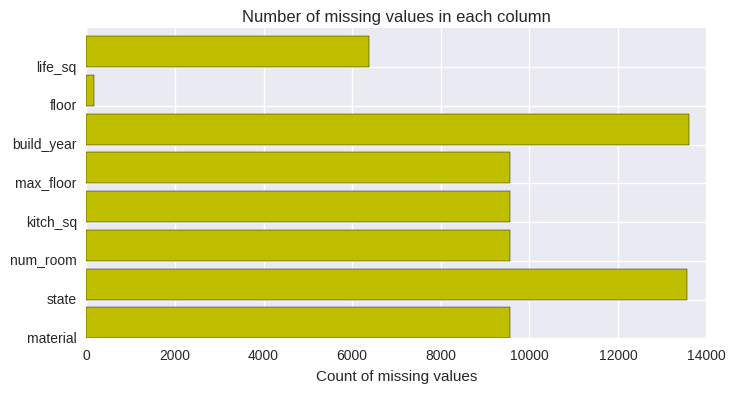

In [40]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
#print missing_df 

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,4))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [35]:
import missingno as msno
msno.bar(train[missingValueColumns],\
            figsize=(20,8),color=(0.5, 0.5, 1),fontsize=12,labels=True,)

ImportError: No module named missingno